In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
google_id = '1teoxduT3bJAkrD0k1YIPn-mbVI83oQox'
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './dados_cvm.csv',
                                    showsize = True)


google_id = '1J0fF-82tDg70wjaNg2Q8OGxPikA7phqp'
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './dados_classes.csv',
                                    showsize = True)


google_id = '12Ior9IH6xpACUIP0qRWCvGNRs9774150'
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './synthetic_data_realistic.csv',
                                    showsize = True)

In [ ]:
df_1 = pd.read_csv('dados_cvm.csv')
df_2 = pd.read_csv('dados_classes.csv')
df = pd.merge(df_1, df_2, on='SK_Documento', how='inner')

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_19908\529873874.py:1: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv('dados_cvm.csv')


# Passo 1: Agregar cotas em Subordinadas e Senior por fundo

In [ ]:
print(f"{len(df.loc[df['Patrimonio_Liquido'] == 0]) / len(df.index) * 100}% dos fundos tem PL == 0")

1.281484012254751% dos fundos tem PL == 0


In [ ]:
print(f"{len(df.loc[df['Patrimonio_Liquido'] < 0]) / len(df.index) * 100}% dos fundos tem PL < 0")

0.09073444492363185% dos fundos tem PL < 0


In [ ]:
print(f"Pré-operação tinhamos {len(df.columns)} colunas e {len(df.index)} linhas")
print(f"Pré-operação tinhamos {df['Classe_Serie'].nunique()} dados únicos na coluna Classe_Serie")

df.loc[df['Classe_Serie'].str.contains("sub", case=False), 'Classe_Serie'] = "Subordinada"
df.loc[df['Classe_Serie'].str.contains("nior", case=False), 'Classe_Serie'] = "Senior"

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")
print(f"Agora temos {df['Classe_Serie'].nunique()} dados únicos na coluna Classe_Serie")


Pré-operação tinhamos 336 colunas e 178543 linhas
Pré-operação tinhamos 57 dados únicos na coluna Classe_Serie
Agora temos 336 colunas e 178543 linhas
Agora temos 2 dados únicos na coluna Classe_Serie


In [ ]:
# Agora vamos criar colunas agregando as 'cols_to_sum' por Subordinada e Senior
classe_serie_types = ["Subordinada", "Senior"]
cols_to_sum = ["Numero_Cotistas", "Quantidade_Cotas", "Valor_Cota", "Rentabilidade", "Valor_Total_Captado", "Quantidade_Cotas_Emitidas", "Valor_Total_Resgates", "Quantidade_Cotas_Resgatadas", "Valor_A_Pagar", "Quantidade_Cotas_A_Resgatar", "Valor_Amortizado_Cota", "Valor_Total_Amortizacao", "Desempenho_Esperado", "Desempenho_Realizado"]
for classe_serie_type in classe_serie_types:
  for col in cols_to_sum:
    df[col + "_" + classe_serie_type] = df[df['Classe_Serie'] == classe_serie_type].groupby('ID_Documento')[col].transform('sum')

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 364 colunas e 178543 linhas


In [ ]:
# Agora vamos remover fileiras duplicadas
df.drop(cols_to_sum, axis=1, inplace=True)
df = df.drop_duplicates()
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 350 colunas e 111476 linhas


In [ ]:
df = df.groupby("ID_Documento", as_index=False).agg("first")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 350 colunas e 57275 linhas


## Passo 2: Agregar Colunas por Prazo
Precisamos reduzir o número de colunas, o primeiro passo para isso é juntar as colunas que envolvem prazo da seguinte maneira:

- Somar campos entre 0 e 90 dias como `Curto Prazo (CP)`
- Somar campos entre 90 e 365 dias como `Médio Prazo (MP)`
- Somar campos acima de 365 dias como `Longo Prazo (LP)`

In [ ]:
# Create Aggregate Columns
step_2_pretreat_col_count = len(df.columns)
df['Carteira_Direitos_Aquisicao_Prazo_CP'] = df['Carteira_Direitos_Aquisicao_Prazo_1_30_dias'] + df['Carteira_Direitos_Aquisicao_Prazo_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Prazo_MP'] = df['Carteira_Direitos_Aquisicao_Prazo_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Prazo_LP'] = df['Carteira_Direitos_Aquisicao_Prazo_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_Acima_1080_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_CP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_1_30_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_MP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_LP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_Acima_1080_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_CP'] = df['Carteira_Direitos_Aquisicao_Pagos_1_30_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_MP'] = df['Carteira_Direitos_Aquisicao_Pagos_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_LP'] = df['Carteira_Direitos_Aquisicao_Pagos_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_1_30_dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_1_30_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_1_30_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_Acima_1080_Dias']
df['Liquidez_CP'] = df['Liquidez_Ate_30_Dias'] + df['Liquidez_Ate_60_Dias'] + df['Liquidez_Ate_90_Dias']
df['Liquidez_MP'] = df['Liquidez_Ate_180_Dias'] + df['Liquidez_Ate_360_Dias']
df['Liquidez_LP'] = df['Liquidez_Acima_360_Dias']

agg_cols_to_drop = ['Carteira_Direitos_Aquisicao_Prazo_1_30_dias', 'Carteira_Direitos_Aquisicao_Prazo_31_60_Dias', 'Carteira_Direitos_Aquisicao_Prazo_61_90_Dias', 'Carteira_Direitos_Aquisicao_Prazo_91_120_Dias', 'Carteira_Direitos_Aquisicao_Prazo_121_150_Dias', 'Carteira_Direitos_Aquisicao_Prazo_151_180_Dias', 'Carteira_Direitos_Aquisicao_Prazo_181_360_Dias', 'Carteira_Direitos_Aquisicao_Prazo_361_720_Dias', 'Carteira_Direitos_Aquisicao_Prazo_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Prazo_Acima_1080_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_1_30_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_31_60_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_61_90_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_91_120_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_121_150_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_151_180_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_181_360_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_361_720_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_Acima_1080_Dias', 'Carteira_Direitos_Aquisicao_Pagos_1_30_Dias', 'Carteira_Direitos_Aquisicao_Pagos_31_60_Dias', 'Carteira_Direitos_Aquisicao_Pagos_61_90_Dias', 'Carteira_Direitos_Aquisicao_Pagos_91_120_Dias', 'Carteira_Direitos_Aquisicao_Pagos_121_150_Dias', 'Carteira_Direitos_Aquisicao_Pagos_151_180_Dias', 'Carteira_Direitos_Aquisicao_Pagos_181_360_Dias', 'Carteira_Direitos_Aquisicao_Pagos_361_720_Dias', 'Carteira_Direitos_Aquisicao_Pagos_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Pagos_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_1_30_dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_1_30_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_1_30_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_Acima_1080_Dias', 'Liquidez_Ate_30_Dias', 'Liquidez_Ate_60_Dias', 'Liquidez_Ate_90_Dias', 'Liquidez_Ate_180_Dias', 'Liquidez_Ate_360_Dias', 'Liquidez_Acima_360_Dias']
df.drop(agg_cols_to_drop, axis=1, inplace=True)
step_2_posttreat_col_count = len(df.columns)

print(f"Dropamos {step_2_pretreat_col_count - step_2_posttreat_col_count} colunas")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropamos 45 colunas
Agora temos 305 colunas e 57275 linhas


# Passo 3: Dropas colunas onde todos os valores são iguais

In [ ]:
# Dropar Colunas onde todos os valores são iguais
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index

print(f"Dropando {len(cols_to_drop)} colunas onde todos os valores são iguais: ")
print(cols_to_drop)
df = df.drop(cols_to_drop, axis=1)

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropando 15 colunas onde todos os valores são iguais: 
Index(['Ativo_Direitos_Sem_Aquisicao_Creditos_Performar',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Empresas_Recuperacao',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Receitas_Publicas',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Fator_Risco',
       'Ativo_Coberturas_Prestadas', 'Carteira_Creditos_Tributarios',
       'Carteira_Royalties', 'Taxas_Titulos_Federais_Juros_Venda_Minina',
       'Taxas_Titulos_Federais_Juros_Venda_Maxima',
       'Taxas_CDB_Desconto_Venda_Minina',
       'Taxas_CDB_Desconto_Venda_Media_Ponderada',
       'Taxas_CDB_Desconto_Venda_Maxima', 'Taxas_CDB_Juros_Venda_Minina',
       'Taxas_CDB_Juros_Venda_Media_Ponderada',
       'Taxas_CDB_Juros_Venda_Maxima'],
      dtype='object')
Agora temos 290 colunas e 57275 linhas


# Passo 4: Somar outros ativos em uma coluna resumida
Aqui vamos somar as seguintas colunas em `Ativo_Outros`

- `Ativo_Valores_Mobiliarios`
- `Ativo_Titulos_Federais`
- `Ativo_CDB`
- `Ativo_Operacoes_Compromissadas`
- `Ativo_Outros_Ativos_Renda_Fixa`
- `Ativo_Cotas_FIDC`
- `Ativo_Warrants`
- `Ativo_Posicao_Derivativos`
- `Ativo_Mercado_Termo`
- `Ativo_Mercado_Opcoes`
- `Ativo_Mercado_Futuro`
- `Ativo_Diferencial_Swap`
- `Ativo_Depositos_Margem`

In [ ]:
# Vamos somar outros ativos
ativos_drop = ["Ativo_Valores_Mobiliarios", "Ativo_Titulos_Federais", "Ativo_CDB", "Ativo_Operacoes_Compromissadas", "Ativo_Outros_Ativos_Renda_Fixa", "Ativo_Cotas_FIDC", "Ativo_Warrants", "Ativo_Posicao_Derivativos", "Ativo_Mercado_Termo", "Ativo_Mercado_Opcoes", "Ativo_Mercado_Futuro", "Ativo_Diferencial_Swap", "Ativo_Depositos_Margem", "Ativo_Debentures", "Ativo_CRI", "Ativo_Notas_Promissorias", "Ativo_Letras Financeiras", "Ativo_Cotas_Fundos_ICVM_555", "Ativo_Outros_Valores_Mobiliarios", "Ativo_Cotas_FIDC_NP", "Ativo_Provisao_Debentures_CRI_NP_LF", "Ativo_Provisao_Cotas_FIDC", "Ativo_Provisao_Outros_Ativos"]

for ativo in ativos_drop:
  df["Ativo_Outros"] = df["Ativo_Outros"] +  df[ativo]

df = df.drop(ativos_drop, axis=1)

print(f"Dropamos {len(ativos_drop)} colunas")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropamos 23 colunas
Agora temos 267 colunas e 57275 linhas


# Passo 5: Criar uma coluna de `Provisao`

In [ ]:
df["Provisao"] = df["Ativo_Direitos_Aquisicao_Provisao_Reducao"] + df["Ativo_Direitos_Sem_Aquisicao_Provisao_Reducao"]
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 268 colunas e 57275 linhas


# Manter apenas as colunas selecionadas

In [ ]:
columns_to_keep = ["Data_Competencia", "CNPJ", 'Nome_Fundo', "CNPJ_Administrador", "Forma_Condominio", "Patrimonio_Liquido", "Carteira_Direitos_Aquisicao_Inadimplentes_CP", "Carteira_Direitos_Aquisicao_Inadimplentes_MP", "Carteira_Direitos_Aquisicao_Inadimplentes_LP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP", "Liquidez_CP", "Liquidez_MP", "Liquidez_LP", "Carteira_Financeiro", "Provisao", "Quantidade_Cotas_Senior", "Valor_Cota_Senior", "Rentabilidade_Senior", "Valor_Total_Captado_Senior", "Valor_Total_Resgates_Senior", "Valor_A_Pagar_Senior", "Quantidade_Cotas_A_Resgatar_Senior", "Valor_Amortizado_Cota_Senior", "Valor_Total_Amortizacao_Senior", "Desempenho_Esperado_Senior", "Desempenho_Realizado_Senior", "Quantidade_Cotas_Subordinada", "Valor_Cota_Subordinada", "Rentabilidade_Subordinada", "Valor_Total_Captado_Subordinada", "Valor_Total_Resgates_Subordinada", "Valor_A_Pagar_Subordinada", "Quantidade_Cotas_A_Resgatar_Subordinada", "Valor_Amortizado_Cota_Subordinada", "Valor_Total_Amortizacao_Subordinada", "Desempenho_Esperado_Subordinada", "Desempenho_Realizado_Subordinada"]
df = df[columns_to_keep]

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 39 colunas e 57275 linhas


# Retirar linhas liquidadas, ou enviadas erradas

Se essa colunas tiverem com valor igual a 0 o fundo está liquidado, ou o informe mensal foi enviado errado

- `Patrimonio_Liquido`
- `Carteira_Direitos_Aquisicao_Inadimplentes_CP`
- `Carteira_Direitos_Aquisicao_Inadimplentes_MP`
- `Carteira_Direitos_Aquisicao_Inadimplentes_LP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP`
- `Liquidez_CP`
- `Liquidez_MP`
- `Liquidez_LP`
- `Carteira_Financeiro`
- `Provisao`
- `Quantidade_Cotas_Senior`
- `Valor_Cota_Senior`
- `Rentabilidade_Senior`
- `Valor_Total_Captado_Senior`
- `Valor_Total_Resgates_Senior`
- `Valor_A_Pagar_Senior`
- `Quantidade_Cotas_A_Resgatar_Senior`
- `Valor_Amortizado_Cota_Senior`
- `Valor_Total_Amortizacao_Senior`
- `Desempenho_Esperado_Senior`
- `Desempenho_Realizado_Senior`
- `Quantidade_Cotas_Subordinada`
- `Valor_Cota_Subordinada`
- `Rentabilidade_Subordinada`
- `Valor_Total_Captado_Subordinada`
- `Valor_Total_Resgates_Subordinada`
- `Valor_A_Pagar_Subordinada`
- `Quantidade_Cotas_A_Resgatar_Subordinada`
- `Valor_Amortizado_Cota_Subordinada`
- `Valor_Total_Amortizacao_Subordinada`
- `Desempenho_Esperado_Subordinada`
- `Desempenho_Realizado_Subordinada`

In [ ]:
colunas = df.columns.tolist()
colunas_padrao = ['CNPJ', 'Nome_Fundo', 'Data_Competencia', 'CNPJ_Administrador', 'Forma_Condominio']
for colunasP in colunas_padrao:
  colunas.remove(colunasP)
colunas

['Patrimonio_Liquido',
 'Carteira_Direitos_Aquisicao_Inadimplentes_CP',
 'Carteira_Direitos_Aquisicao_Inadimplentes_MP',
 'Carteira_Direitos_Aquisicao_Inadimplentes_LP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP',
 'Liquidez_CP',
 'Liquidez_MP',
 'Liquidez_LP',
 'Carteira_Financeiro',
 'Provisao',
 'Quantidade_Cotas_Senior',
 'Valor_Cota_Senior',
 'Rentabilidade_Senior',
 'Valor_Total_Captado_Senior',
 'Valor_Total_Resgates_Senior',
 'Valor_A_Pagar_Senior',
 'Quantidade_Cotas_A_Resgatar_Senior',
 'Valor_Amortizado_Cota_Senior',
 'Valor_Total_Amortizacao_Senior',
 'Desempenho_Esperado_Senior',
 'Desempenho_Realizado_Senior',
 'Quantidade_Cotas_Subordinada',
 'Valor_Cota_Subordinada',
 'Rentabilidade_Subordinada',
 'Valor_Total_Captado_Subordinada',
 'Valor_Total_Resgates_Subordinada',
 'Valor_A_Pagar_Subordinada',
 'Quantidade_Cotas_A_Resgatar_Subordinada',
 'Valor_Amortiza

In [ ]:
linhas_liquidadas = df[df[colunas].eq(0).all(axis=1)]
linhas_liquidadas

,Data_Competencia,CNPJ,Nome_Fundo,CNPJ_Administrador,Forma_Condominio,Patrimonio_Liquido,Carteira_Direitos_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Aquisicao_Inadimplentes_LP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP,...,Valor_Cota_Subordinada,Rentabilidade_Subordinada,Valor_Total_Captado_Subordinada,Valor_Total_Resgates_Subordinada,Valor_A_Pagar_Subordinada,Quantidade_Cotas_A_Resgatar_Subordinada,Valor_Amortizado_Cota_Subordinada,Valor_Total_Amortizacao_Subordinada,Desempenho_Esperado_Subordinada,Desempenho_Realizado_Subordinada
166,2020-11-30,31809006000138,FUNDO DE INVES TIMENTO EM DIREITOS CREDITORIOS...,1.348679e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,2020-11-30,29883381000186,FIDC RECEBÍVEIS ENEVA - FUNDO DE INVESTIMENTOS...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341,2020-11-30,31151932000169,FIDC VX XXV - FUNDO DE INVESTIMENTOS EM DIREIT...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,2020-11-30,29492796000129,ASIMOV FUNDO DE INVESTIMENTO EM COTAS DE FUNDO...,3.317692e+12,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,2020-11-30,28472373000184,FIDC ENEVA RECEBÍVEIS - FUNDO DE INVESTIMENTOS...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47020,2019-03-31,29044084000147,FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS ...,2.201501e+12,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47518,2019-04-30,22483823000158,DRIVER BRASIL THREE BANCO VOLKSWAGEN FIDC FINA...,6.667000e+10,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54896,2020-07-31,17288447000100,MULTI7 FUNDO DE INVESTIMENTO EM DIREITOS CREDI...,6.228539e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57152,2020-09-30,26648825000100,ÁTRIO CREDITOO FUNDO DE INVESTIMENTO EM DIREIT...,6.228539e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.drop(linhas_liquidadas.index)

### Substituindo valores Nulos

In [ ]:
colunas = ['Carteira_Direitos_Aquisicao_Inadimplentes_CP', 'Carteira_Direitos_Aquisicao_Inadimplentes_MP', 'Carteira_Direitos_Aquisicao_Inadimplentes_LP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP', 'Liquidez_CP', 'Liquidez_MP', 'Liquidez_LP']
for coluna in colunas:
  df[coluna] = df[coluna].fillna(0)


# Treinando Modelo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=1000)),
    ('SVM', SVC()),
    ('Logistic Regression', LogisticRegression()),
    ('Bagging Classifier', BaggingClassifier()),
    ('AdaBoost Classifier', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Gerar dados sintéticos

In [ ]:
synthetic_data_realistic = pd.read_csv('synthetic_data_realistic.csv', encoding='latin1')

In [ ]:
nomes = ['FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS INDIGO BARTER', 'FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS BRAVA CHALLENGE', 'CREDIHOME FUNDO DE INVESTIMENTO EM DIREITOS CREDITORIOS', 'RUBI FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS MULTISETORIAL', 'FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS BULLLA', 'LS INTERBANK FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS', 'TURQUESA - FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS']
def analisa_nomes(valor):
  for nome in nomes:
    if valor == nome:
      return 1
    else:
      return 0

df['FIDCs_em_alerta'] = df.Nome_Fundo.apply(analisa_nomes)
df['FIDCs_em_alerta'].value_counts()

FIDCs_em_alerta
0    56636
1       46
Name: count, dtype: int64

In [ ]:
df = df.dropna(subset=['Forma_Condominio'])

In [ ]:
df.Forma_Condominio.unique()

array(['ABERTO', 'FECHADO'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
var_mod =['Forma_Condominio']
le = LabelEncoder()
for i in var_mod:
  df[i] = le.fit_transform(df[i])

In [ ]:
df.Forma_Condominio.unique()

array([0, 1])

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(53462, 40)

### Fazendo UnderSampling

In [ ]:
synthetic_data_realistic.FIDCs_em_alerta.value_counts()

FIDCs_em_alerta
0    34756
1    15244
Name: count, dtype: int64

Separando os fundos que quebraram e não quebraram

In [ ]:
fundos_Nao_Quebraram_Sinteticos = synthetic_data_realistic.loc[synthetic_data_realistic.FIDCs_em_alerta == 0]
fundos_Quebraram_Sinteticos = synthetic_data_realistic.loc[synthetic_data_realistic.FIDCs_em_alerta == 1]

Deixando os fundos que quebraram e não quebraram com o mesmo tamanho

In [ ]:
fundos_Nao_Quebraram_Sinteticos = fundos_Nao_Quebraram_Sinteticos.sample(n=15244, random_state=42)

Juntando eles em um DataFrame

In [ ]:
synthetic_data_realistic = pd.concat([fundos_Nao_Quebraram_Sinteticos, fundos_Quebraram_Sinteticos], axis=0)

In [ ]:
synthetic_data_realistic.shape

(30488, 40)

In [ ]:
synthetic_data_realistic.FIDCs_em_alerta.value_counts()

FIDCs_em_alerta
0    15244
1    15244
Name: count, dtype: int64

## Analisando o treinamento de modelos

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Model: Random Forest
Accuracy: 0.8821779955856496
Confusion Matrix:
[[47117  6299]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     53416
           1       0.01      1.00      0.01        46

    accuracy                           0.88     53462
   macro avg       0.50      0.94      0.48     53462
weighted avg       1.00      0.88      0.94     53462



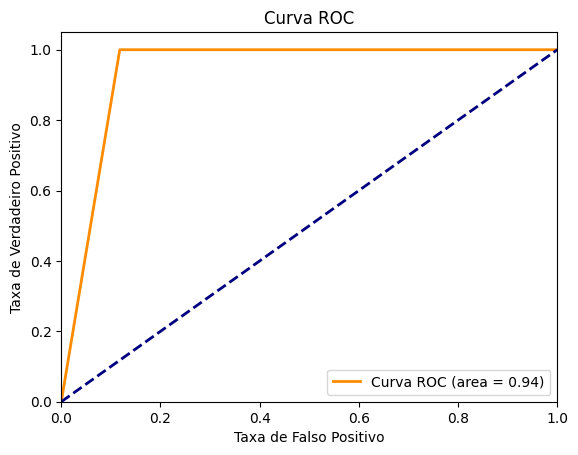

Model: SVM
Accuracy: 0.9514234409487112
Confusion Matrix:
[[50821  2595]
 [    2    44]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     53416
           1       0.02      0.96      0.03        46

    accuracy                           0.95     53462
   macro avg       0.51      0.95      0.50     53462
weighted avg       1.00      0.95      0.97     53462



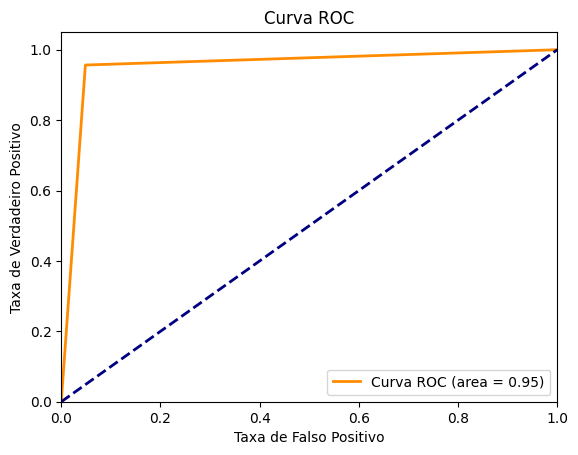

Model: Logistic Regression
Accuracy: 0.8900527477460626
Confusion Matrix:
[[47542  5874]
 [    4    42]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53416
           1       0.01      0.91      0.01        46

    accuracy                           0.89     53462
   macro avg       0.50      0.90      0.48     53462
weighted avg       1.00      0.89      0.94     53462



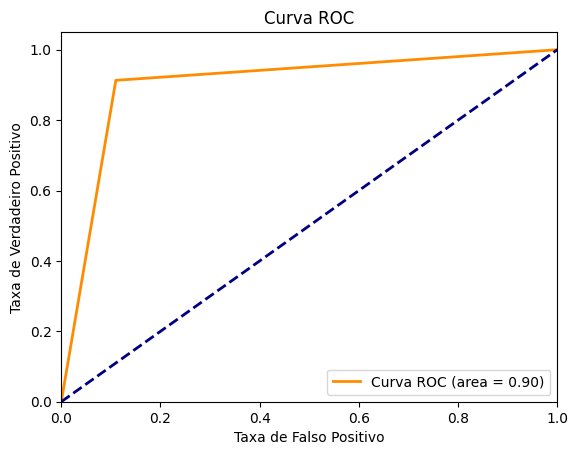

Model: Bagging Classifier
Accuracy: 0.8024578205080244
Confusion Matrix:
[[42855 10561]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.80     53462
   macro avg       0.50      0.90      0.45     53462
weighted avg       1.00      0.80      0.89     53462



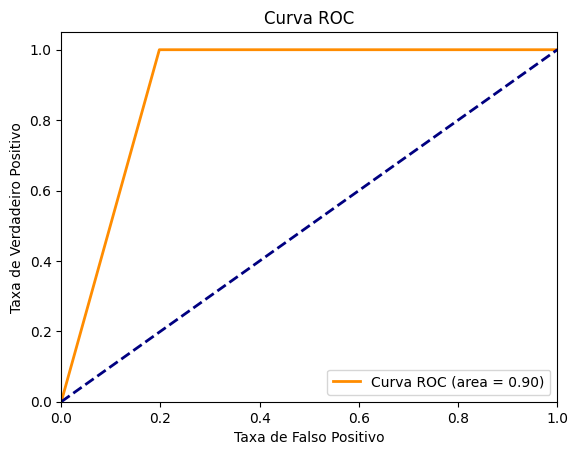

Model: AdaBoost Classifier
Accuracy: 0.8247914406494332
Confusion Matrix:
[[44049  9367]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.82     53462
   macro avg       0.50      0.91      0.46     53462
weighted avg       1.00      0.82      0.90     53462



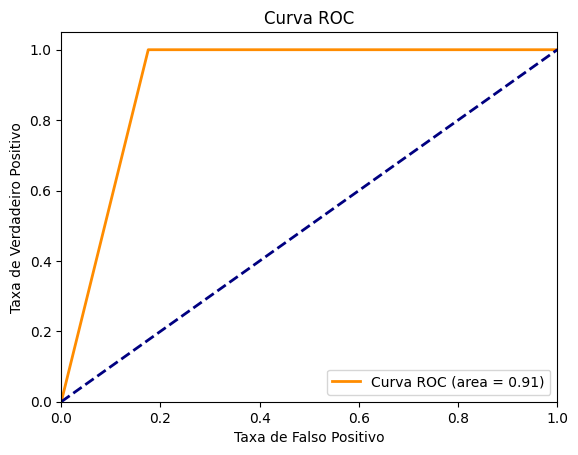

Model: Gradient Boosting
Accuracy: 0.8174965395982193
Confusion Matrix:
[[43659  9757]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.82     53462
   macro avg       0.50      0.91      0.45     53462
weighted avg       1.00      0.82      0.90     53462



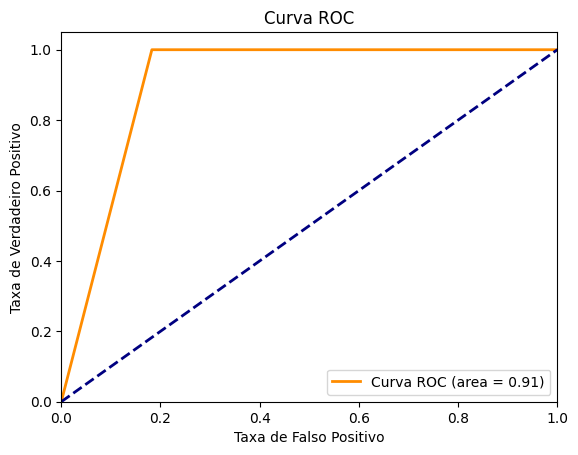

In [ ]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{confusion}')
    print(f'Classification Report:\n{classification_rep}')

    if hasattr(model, 'predict_proba'):

      y_prob = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plote a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    print('=' * 70)
    print('=' * 70)

# Avaliando as Features utilizadas

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
scaler = MinMaxScaler()


column_names = X_train.columns.tolist()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=column_names)

column_names = X_test.columns.tolist()
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=column_names)


In [ ]:
X_train.Patrimonio_Liquido.describe()

count    30488.000000
mean         0.031573
std          0.104743
min          0.000000
25%          0.004372
50%          0.008001
75%          0.031737
max          1.000000
Name: Patrimonio_Liquido, dtype: float64

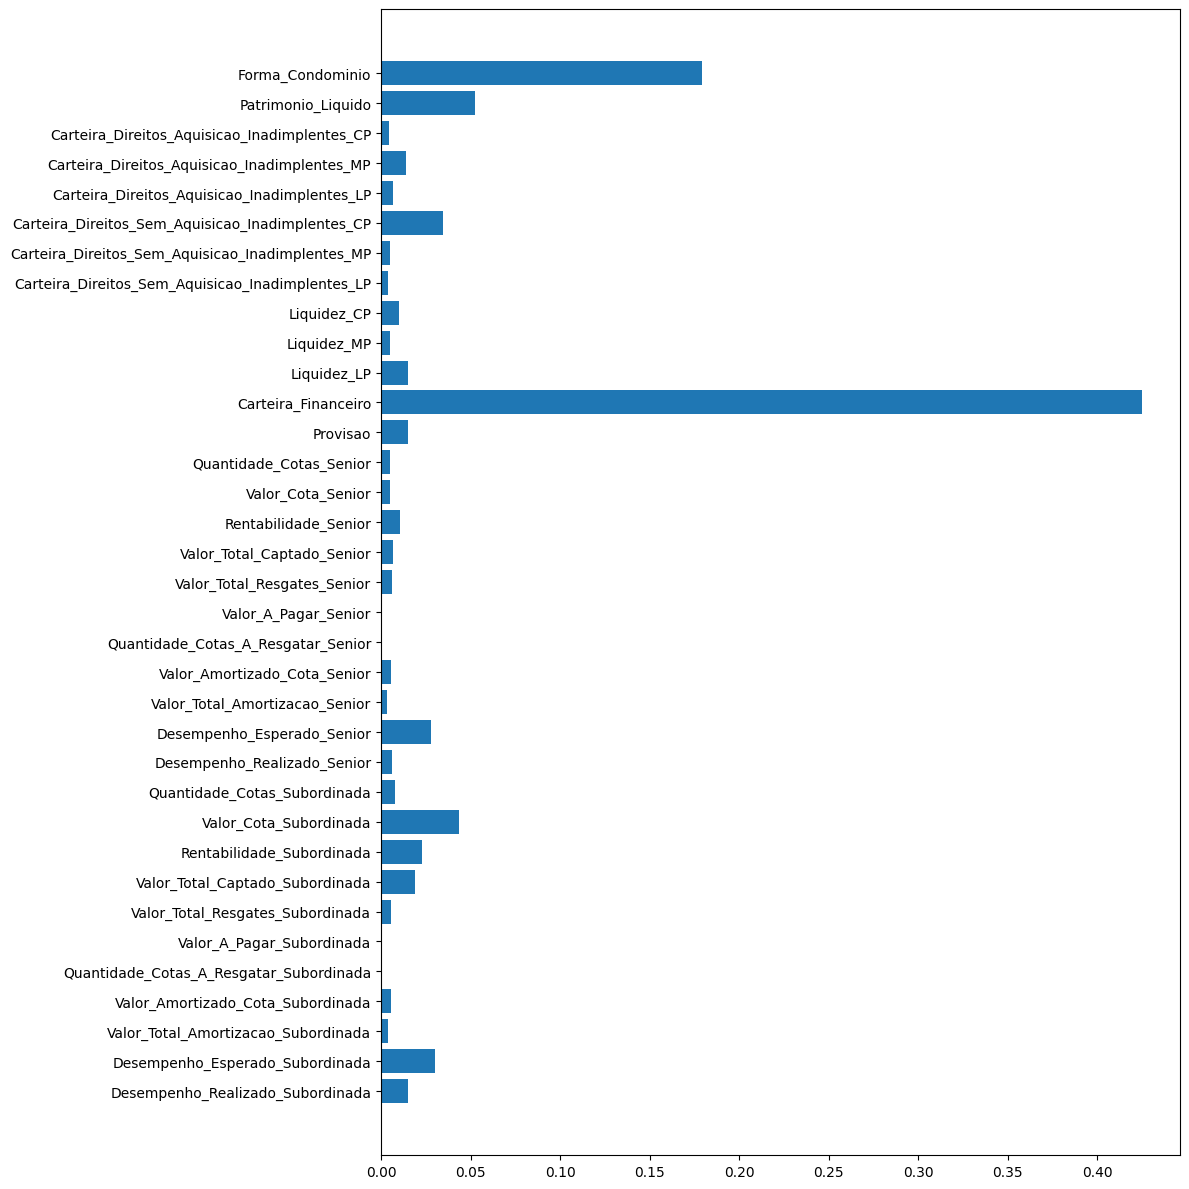

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Carregue seus dados e divida entre features (X) e variável alvo (y)

# Crie o modelo XGBoost
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Obtenha as importâncias das features
feature_importances = model.feature_importances_

feature_names = X_train.columns

# Aumente o espaçamento entre as barras e adicione espaçamento entre as ticks do eixo Y
plt.figure(figsize=(12, 12))
plt.barh(feature_names, feature_importances)
plt.gca().invert_yaxis()  # Inverter o eixo Y para que as features apareçam na ordem correta
plt.tight_layout()  # Para garantir que as labels não se sobreponham
plt.show()

In [ ]:
feature_names[-1]

'Desempenho_Realizado_Subordinada'

In [ ]:
len(feature_names)

35

In [ ]:
modelo_base = RandomForestClassifier(n_estimators=100, random_state=42)

# Crie um objeto RFECV com validação cruzada.
rfecv = RFECV(estimator=modelo_base, step=1, cv=StratifiedKFold(5), scoring='precision')

# Ajuste o RFECV ao seu conjunto de dados.
rfecv.fit(X_train, y_train)

# Imprima os resultados.
print("Número ótimo de features: %d" % rfecv.n_features_)
print("Ranking de features: %s" % rfecv.ranking_)

# Visualize a importância das features.
importances = rfecv.estimator_.feature_importances_
print("Importância das features:")
for i, importance in enumerate(importances):
    print("Feature %d: %f" % (i+1, importance))

# Você pode acessar as features selecionadas usando:
features_selecionadas = np.where(rfecv.support_)[0]

Número ótimo de features: 34
Ranking de features: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
Importância das features:
Feature 1: 0.014115
Feature 2: 0.104721
Feature 3: 0.063185
Feature 4: 0.048151
Feature 5: 0.018836
Feature 6: 0.050573
Feature 7: 0.011427
Feature 8: 0.004254
Feature 9: 0.013403
Feature 10: 0.010151
Feature 11: 0.049880
Feature 12: 0.172426
Feature 13: 0.061796
Feature 14: 0.007820
Feature 15: 0.004660
Feature 16: 0.034739
Feature 17: 0.008075
Feature 18: 0.006645
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.008137
Feature 22: 0.004289
Feature 23: 0.024526
Feature 24: 0.035354
Feature 25: 0.024255
Feature 26: 0.026992
Feature 27: 0.035505
Feature 28: 0.034183
Feature 29: 0.012125
Feature 30: 0.000000
Feature 31: 0.008796
Feature 32: 0.002880
Feature 33: 0.051294
Feature 34: 0.046805


In [ ]:
X_train

,Forma_Condominio,Patrimonio_Liquido,Carteira_Direitos_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Aquisicao_Inadimplentes_LP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP,Liquidez_CP,Liquidez_MP,...,Valor_Cota_Subordinada,Rentabilidade_Subordinada,Valor_Total_Captado_Subordinada,Valor_Total_Resgates_Subordinada,Valor_A_Pagar_Subordinada,Quantidade_Cotas_A_Resgatar_Subordinada,Valor_Amortizado_Cota_Subordinada,Valor_Total_Amortizacao_Subordinada,Desempenho_Esperado_Subordinada,Desempenho_Realizado_Subordinada
0,1.0,0.004597,0.000000,0.000000,0.000604,0.002888,0.000000,0.000000,0.000318,5.739480e-04,...,0.000816,0.696764,0.000000,0.000899,0.0,0.0,0.000332,0.000295,0.177326,0.697510
1,1.0,0.012147,0.006680,0.000000,0.003814,0.001591,0.001033,0.000102,0.000899,7.249624e-04,...,0.004794,0.698488,0.001108,0.002205,0.0,0.0,0.000128,0.000000,0.201801,0.697101
2,1.0,0.004987,0.000058,0.007497,0.001691,0.000000,0.000393,0.000000,0.000448,6.362901e-04,...,0.001352,0.678295,0.001204,0.000467,0.0,0.0,0.000740,0.000000,0.126399,0.678851
3,0.0,0.006489,0.000000,0.001405,1.000000,0.000840,0.000000,0.000000,0.000986,4.388611e-04,...,0.001892,0.692014,0.000264,0.000000,0.0,0.0,0.000000,0.000000,0.174972,0.693026
4,0.0,0.001735,0.003467,0.003034,0.020371,0.008469,0.000000,0.000000,0.000000,4.322186e-08,...,0.002231,0.719514,0.000685,0.000000,0.0,0.0,0.000000,0.000000,0.206445,0.699847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,0.041261,0.144345,0.473884,0.127075,0.000000,0.000000,0.001287,0.000000,3.890277e-04,...,0.001223,0.653100,0.004839,0.000309,0.0,0.0,0.000503,0.000000,0.207389,0.651093
30484,1.0,0.043101,0.052952,0.361843,0.115933,0.000000,0.000000,0.000004,0.000000,0.000000e+00,...,0.001000,0.715195,0.001725,0.000467,0.0,0.0,0.000720,0.000000,0.216988,0.718605
30485,1.0,0.008435,0.064428,0.316324,0.001369,0.000210,0.000664,0.000000,0.000543,2.427883e-04,...,0.001697,0.931697,0.002134,0.000673,0.0,0.0,0.000727,0.000550,0.196423,0.933171
30486,1.0,0.010471,0.063468,0.328069,0.000000,0.000000,0.000000,0.000000,0.001100,8.074715e-05,...,0.001597,0.925827,0.000000,0.000527,0.0,0.0,0.000161,0.000000,0.196978,0.927925


In [ ]:
X_test

,Forma_Condominio,Patrimonio_Liquido,Carteira_Direitos_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Aquisicao_Inadimplentes_LP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP,Liquidez_CP,Liquidez_MP,...,Valor_Cota_Subordinada,Rentabilidade_Subordinada,Valor_Total_Captado_Subordinada,Valor_Total_Resgates_Subordinada,Valor_A_Pagar_Subordinada,Quantidade_Cotas_A_Resgatar_Subordinada,Valor_Amortizado_Cota_Subordinada,Valor_Total_Amortizacao_Subordinada,Desempenho_Esperado_Subordinada,Desempenho_Realizado_Subordinada
0,0.0,0.001879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.163442e-07,0.000000,...,0.000366,0.697790,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.697790
1,1.0,0.003822,0.000000,0.000000,0.000000,0.167343,0.004500,0.000000,0.000000e+00,0.000000,...,0.004080,0.712781,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.697790
2,0.0,0.015052,0.000748,0.000417,0.000000,0.000000,0.000000,0.000000,6.643058e-04,0.000956,...,1.266207,0.671994,0.0,0.0,0.0,0.0,0.0,0.0,0.183970,0.671994
3,1.0,0.004840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.152415e-03,0.000803,...,0.000395,0.705668,0.0,0.0,0.0,0.0,0.0,0.0,0.183970,0.705668
4,0.0,0.006533,0.000599,0.000000,0.249642,0.077701,0.653034,0.680437,4.389763e-03,0.003882,...,0.013917,0.693963,0.0,0.0,0.0,0.0,0.0,0.0,0.149543,0.693963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53457,0.0,0.019361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.004488,...,0.000366,0.692612,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.692612
53458,0.0,0.018724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.002241,...,0.000366,0.682933,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.682933
53459,0.0,0.018261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000366,0.686625,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.686625
53460,0.0,0.017829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000366,0.687120,0.0,0.0,0.0,0.0,0.0,0.0,0.178857,0.687120


In [ ]:
X_train = X_train.iloc[:, features_selecionadas]


In [ ]:
X_test = X_test.iloc[:, features_selecionadas]

In [ ]:
X_train

,Forma_Condominio,Patrimonio_Liquido,Carteira_Direitos_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Aquisicao_Inadimplentes_LP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP,Liquidez_CP,Liquidez_MP,...,Quantidade_Cotas_Subordinada,Valor_Cota_Subordinada,Rentabilidade_Subordinada,Valor_Total_Captado_Subordinada,Valor_Total_Resgates_Subordinada,Valor_A_Pagar_Subordinada,Valor_Amortizado_Cota_Subordinada,Valor_Total_Amortizacao_Subordinada,Desempenho_Esperado_Subordinada,Desempenho_Realizado_Subordinada
0,1.0,0.004597,0.000000,0.000000,0.000604,0.002888,0.000000,0.000000,0.000318,5.739480e-04,...,0.000000,0.000816,0.696764,0.000000,0.000899,0.0,0.000332,0.000295,0.177326,0.697510
1,1.0,0.012147,0.006680,0.000000,0.003814,0.001591,0.001033,0.000102,0.000899,7.249624e-04,...,0.000357,0.004794,0.698488,0.001108,0.002205,0.0,0.000128,0.000000,0.201801,0.697101
2,1.0,0.004987,0.000058,0.007497,0.001691,0.000000,0.000393,0.000000,0.000448,6.362901e-04,...,0.000494,0.001352,0.678295,0.001204,0.000467,0.0,0.000740,0.000000,0.126399,0.678851
3,0.0,0.006489,0.000000,0.001405,1.000000,0.000840,0.000000,0.000000,0.000986,4.388611e-04,...,0.000000,0.001892,0.692014,0.000264,0.000000,0.0,0.000000,0.000000,0.174972,0.693026
4,0.0,0.001735,0.003467,0.003034,0.020371,0.008469,0.000000,0.000000,0.000000,4.322186e-08,...,0.000000,0.002231,0.719514,0.000685,0.000000,0.0,0.000000,0.000000,0.206445,0.699847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,0.041261,0.144345,0.473884,0.127075,0.000000,0.000000,0.001287,0.000000,3.890277e-04,...,0.001839,0.001223,0.653100,0.004839,0.000309,0.0,0.000503,0.000000,0.207389,0.651093
30484,1.0,0.043101,0.052952,0.361843,0.115933,0.000000,0.000000,0.000004,0.000000,0.000000e+00,...,0.001879,0.001000,0.715195,0.001725,0.000467,0.0,0.000720,0.000000,0.216988,0.718605
30485,1.0,0.008435,0.064428,0.316324,0.001369,0.000210,0.000664,0.000000,0.000543,2.427883e-04,...,0.000410,0.001697,0.931697,0.002134,0.000673,0.0,0.000727,0.000550,0.196423,0.933171
30486,1.0,0.010471,0.063468,0.328069,0.000000,0.000000,0.000000,0.000000,0.001100,8.074715e-05,...,0.000000,0.001597,0.925827,0.000000,0.000527,0.0,0.000161,0.000000,0.196978,0.927925


Model: Random Forest
Accuracy: 0.8803262130111107
Confusion Matrix:
[[47018  6398]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     53416
           1       0.01      1.00      0.01        46

    accuracy                           0.88     53462
   macro avg       0.50      0.94      0.48     53462
weighted avg       1.00      0.88      0.94     53462



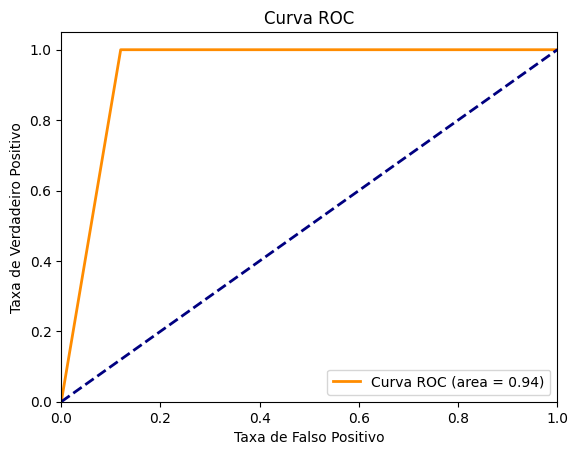

Model: SVM
Accuracy: 0.9514047360742209
Confusion Matrix:
[[50820  2596]
 [    2    44]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     53416
           1       0.02      0.96      0.03        46

    accuracy                           0.95     53462
   macro avg       0.51      0.95      0.50     53462
weighted avg       1.00      0.95      0.97     53462



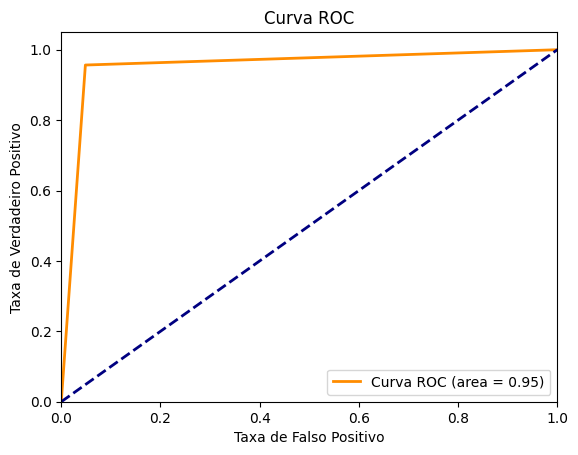

Model: Logistic Regression
Accuracy: 0.8900527477460626
Confusion Matrix:
[[47542  5874]
 [    4    42]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     53416
           1       0.01      0.91      0.01        46

    accuracy                           0.89     53462
   macro avg       0.50      0.90      0.48     53462
weighted avg       1.00      0.89      0.94     53462



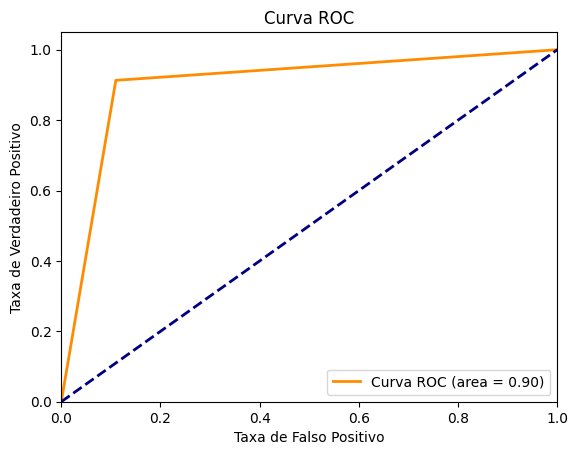

Model: Bagging Classifier
Accuracy: 0.8272230743331712
Confusion Matrix:
[[44179  9237]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.83     53462
   macro avg       0.50      0.91      0.46     53462
weighted avg       1.00      0.83      0.90     53462



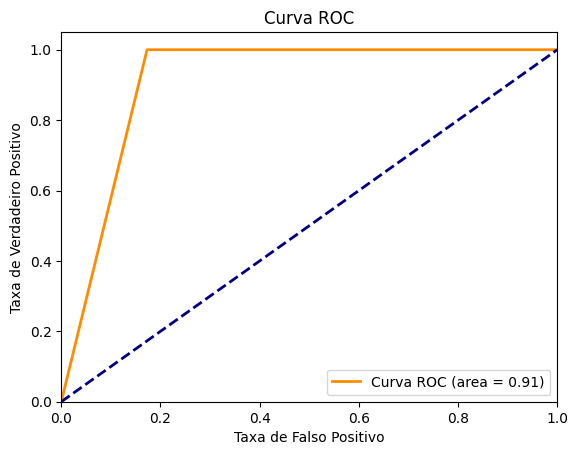

Model: AdaBoost Classifier
Accuracy: 0.8247914406494332
Confusion Matrix:
[[44049  9367]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.82     53462
   macro avg       0.50      0.91      0.46     53462
weighted avg       1.00      0.82      0.90     53462



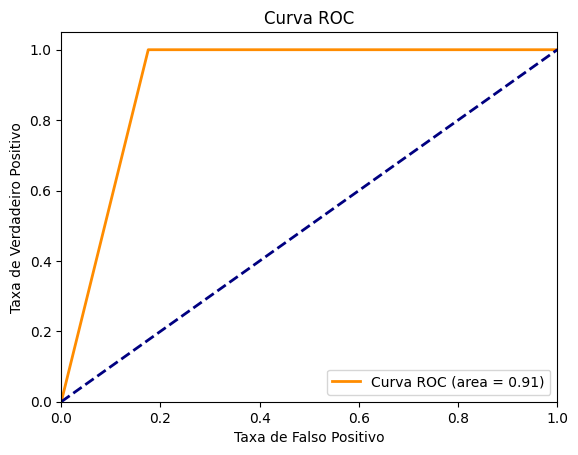

Model: Gradient Boosting
Accuracy: 0.8162059032583892
Confusion Matrix:
[[43590  9826]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     53416
           1       0.00      1.00      0.01        46

    accuracy                           0.82     53462
   macro avg       0.50      0.91      0.45     53462
weighted avg       1.00      0.82      0.90     53462



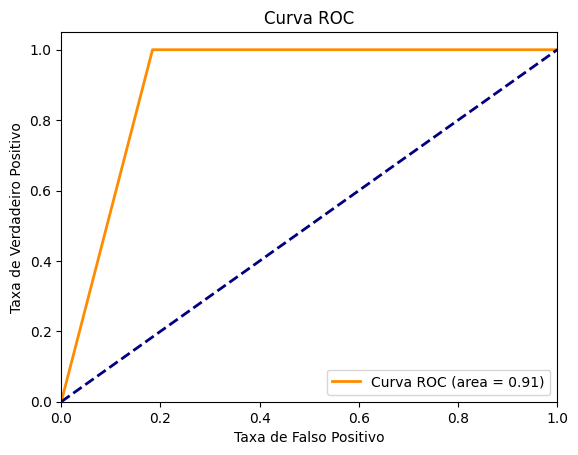

In [ ]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{confusion}')
    print(f'Classification Report:\n{classification_rep}')

    if hasattr(model, 'predict_proba'):

      y_prob = model.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plote a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    print('=' * 70)
    print('=' * 70)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Realize a validação cruzada com 5 dobras (k=5)
scores = cross_val_score(clf, X_train, y_train, cv=5)

# Imprima as pontuações de validação cruzada
print("Pontuações de validação cruzada:", scores)

# Calcule a média das pontuações
mean_score = np.mean(scores)
print("Média das pontuações:", mean_score)

Pontuações de validação cruzada: [0.9375205  0.93784847 0.94047229 0.94275873 0.94095457]
Média das pontuações: 0.9399109122106142


##Treinando modelo com deep learning

In [ ]:
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation='relu', input_dim=35))  # Camada de entrada com ativação ReLU
model.add(keras.layers.Dense(units=32, activation='relu'))  # Camada oculta com ativação ReLU
model.add(keras.layers.Dense(units=1, activation='linear'))  # Camada de saída (1 neurônio para regressão)

# Compilando o modelo
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Treinando o modelo
model.fit(X_train, y_train, epochs=50, batch_size=2048, verbose=1)

# Avaliando o modelo no conjunto de teste
mse, mae = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

# Fazendo previsões
predictions = model.predict(X_test)

# Exemplo de previsões para algumas amostras de teste
for i in range(5):
    print(f'Amostra {i+1}: Valor Real = {y_test[i]:.2f}, Previsão = {predictions[i][0]:.2f}')

Epoch 1/50
15/15 [==============================] - 3s 3ms/step - loss: 0.1942 - mae: 0.4232
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1471 - mae: 0.3477
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1241 - mae: 0.2883
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1139 - mae: 0.2638
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1069 - mae: 0.2491
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1022 - mae: 0.2374
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0987 - mae: 0.2262
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0957 - mae: 0.2179
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0932 - mae: 0.2106
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.0913 - mae: 0.2048
Epoch 11/50
15/15 [==============================] - 0s 2ms/step - lo

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

C:\Users\Marcelo\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Marcelo\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

In [ ]:
y_pred = model.predict(X_test)

1671/1671 [==============================] - 2s 898us/step


In [ ]:
from sklearn.metrics import recall_score


y_pred_classes = (y_pred > 0.5).astype(int)

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calcule a acurácia e o recall
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print("Matriz de Confusão:\n", conf_matrix)
print("Acurácia:", accuracy)
print("Recall:", recall)

Matriz de Confusão:
 [[47309  6107]
 [    1    45]]
Acurácia: 0.8857506266132954
Recall: 0.9782608695652174


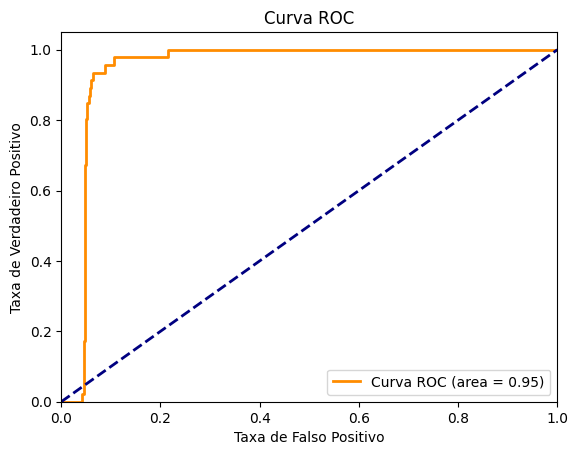

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# model.save('meu_modelo_DL.h5')

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Criação do modelo Keras
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='linear')  # Usar linear para regressão
])

# Compilação do modelo
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Ajuste a taxa de aprendizado conforme necessário
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Treinamento com callback para parar em caso de divergência
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=1024, validation_split=0.1, callbacks=[early_stopping])

# Avaliação do modelo no conjunto de teste
loss = model.evaluate(X_test, y_test)
print(f"Loss no conjunto de teste: {loss:.4f}")

# Faça previsões
y_pred = model.predict(X_test)

Epoch 1/100
27/27 [==============================] - 0s 8ms/step - loss: 0.1565 - val_loss: 0.1495
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1153 - val_loss: 0.1493
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1047 - val_loss: 0.1292
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0974 - val_loss: 0.1376
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0922 - val_loss: 0.1319
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0887 - val_loss: 0.1137
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0863 - val_loss: 0.1261
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0845 - val_loss: 0.1206
Epoch 9/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0832 - val_loss: 0.1206
Epoch 10/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0820 - val_loss: 0.1142
Epoch 11/

In [ ]:
y_pred = model.predict(X_test)

1671/1671 [==============================] - 1s 875us/step


In [ ]:
y_pred_classes = (y_pred > 0.5).astype(int)

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calcule a acurácia e o recall
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print("Matriz de Confusão:\n", conf_matrix)
print("Acurácia:", accuracy)
print("Recall:", recall)

Matriz de Confusão:
 [[45351  8065]
 [    1    45]]
Acurácia: 0.8491264823613034
Recall: 0.9782608695652174


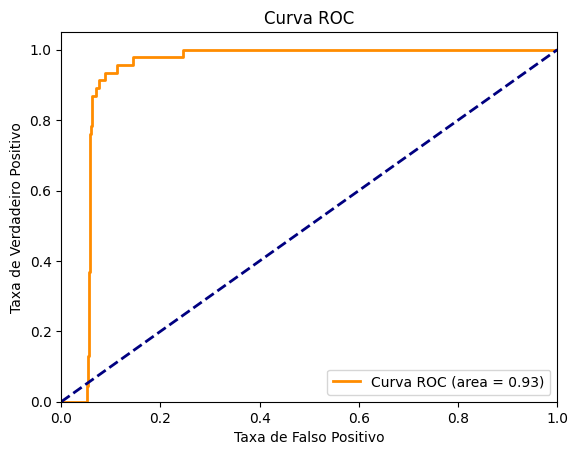

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


1671/1671 [==============================] - 2s 910us/step
Acurácia: 0.8491264823613034
Precisão: 0.005548705302096177
Recall: 0.9782608695652174
F1-Score: 0.011034820990681706
Matriz de Confusão:
 [[45351  8065]
 [    1    45]]


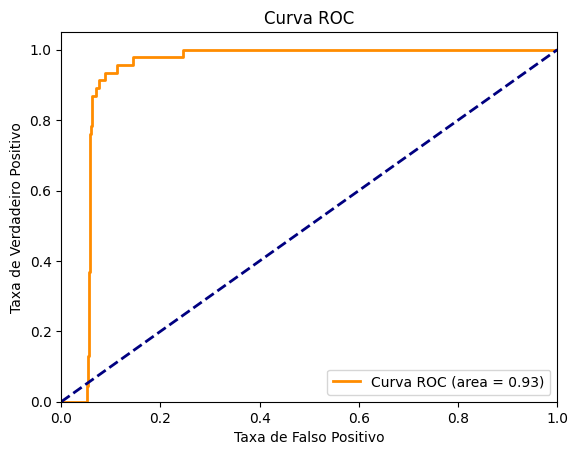

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Métricas
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
confusion = confusion_matrix(y_test, y_pred_classes)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Matriz de Confusão:\n", confusion)

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
X = synthetic_data_realistic
y = df

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Epoch 1/100
14/14 [==============================] - 1s 23ms/step - loss: 0.6856 - accuracy: 0.5602 - val_loss: 0.7209 - val_accuracy: 0.2949
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 0.6331 - accuracy: 0.7262 - val_loss: 0.6952 - val_accuracy: 0.4785
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5713 - accuracy: 0.7876 - val_loss: 0.6663 - val_accuracy: 0.5707
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5015 - accuracy: 0.8163 - val_loss: 0.5784 - val_accuracy: 0.6796
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4353 - accuracy: 0.8351 - val_loss: 0.5252 - val_accuracy: 0.7340
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3804 - accuracy: 0.8523 - val_loss: 0.4530 - val_accuracy: 0.7694
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3444 - accuracy: 0.8552 - val_loss: 0.4347 - val_accuracy: 0.7753
Epoch 8/100


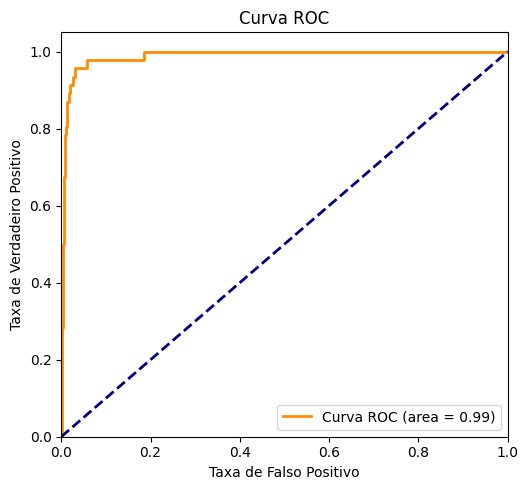

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')  # Usar sigmoid para classificação binária
])

# Compilação do modelo
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_split=0.1)

# Previsões
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Métricas
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
confusion = confusion_matrix(y_test, y_pred_classes)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Matriz de Confusão:\n", confusion)

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva de Aprendizado
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Amostras de Treinamento")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Curva de aprendizado
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Score de Treinamento")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Score de Validação Cruzada")
    axes[0].legend(loc="best")

    # Tempo de encaixe
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Amostras de Treinamento")
    axes[1].set_ylabel("Tempo (s)")
    axes[1].set_title("Tempo de Treinamento")

plt.tight_layout()
plt.show()

C:\Users\Marcelo\AppData\Local\Temp\ipykernel_19908\2387252677.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=2500, batch_size=4096, verbose=0)


191/191 [==============================] - 0s 861us/step
Acurácia da Validação Cruzada: 93.50%
1671/1671 [==============================] - 1s 868us/step
Acurácia: 0.8954397515992668
Precisão: 0.008161816891412349
Recall: 1.0
F1-Score: 0.016191481872580078
Matriz de Confusão:
 [[47826  5590]
 [    0    46]]
763/763 [==============================] - 1s 869us/step


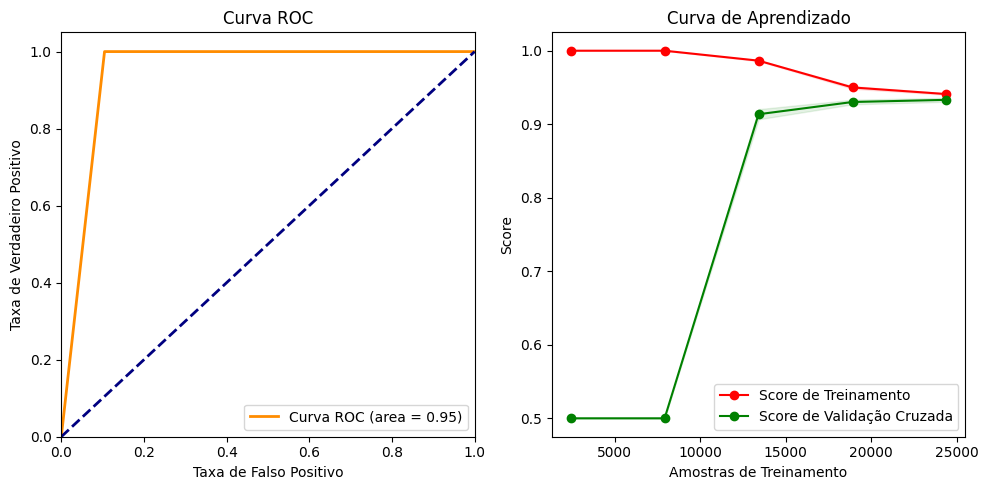

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier


# Função para criar o modelo Keras
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Crie um wrapper do Keras para uso com scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=2500, batch_size=4096, verbose=0)

# Treinamento do modelo usando validação cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

print("Acurácia da Validação Cruzada: %.2f%%" % (results.mean()*100))

# Treinamento do modelo com todos os dados de treinamento
model.fit(X_train, y_train, epochs=2500, batch_size=4096, verbose=0)

# Previsões
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Métricas
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
confusion = confusion_matrix(y_test, y_pred_classes)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Matriz de Confusão:\n", confusion)

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva de Aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=kfold, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.subplot(1, 2, 2)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Score de Treinamento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Score de Validação Cruzada")
plt.xlabel("Amostras de Treinamento")
plt.ylabel("Score")
plt.title("Curva de Aprendizado")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow import keras

In [ ]:
# model.model.save('meu_modelo_DL_2500.h5')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')  # Usar sigmoid para classificação binária
])

# Compilação do modelo
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping: Defina a condição para parar o treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=10000, verbose=1, restore_best_weights=True)

# Treinamento do modelo com Early Stopping
history = model.fit(X_train, y_train, epochs=1000000, batch_size=4096,
                    validation_split=0.1, verbose=1, callbacks=[early_stopping])

# Avaliação do modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss no conjunto de teste: {loss:.4f}")
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

A saída de streaming foi truncada nas últimas 5000 linhas.
7/7 [==============================] - 0s 9ms/step - loss: 0.1181 - accuracy: 0.9477 - val_loss: 0.3146 - val_accuracy: 0.9046
Epoch 8370/1000000
7/7 [==============================] - 0s 9ms/step - loss: 0.1176 - accuracy: 0.9486 - val_loss: 0.3044 - val_accuracy: 0.9069
Epoch 8371/1000000
7/7 [==============================] - 0s 9ms/step - loss: 0.1178 - accuracy: 0.9490 - val_loss: 0.3140 - val_accuracy: 0.9039
Epoch 8372/1000000
7/7 [==============================] - 0s 11ms/step - loss: 0.1178 - accuracy: 0.9487 - val_loss: 0.2995 - val_accuracy: 0.9108
Epoch 8373/1000000
7/7 [==============================] - 0s 9ms/step - loss: 0.1182 - accuracy: 0.9479 - val_loss: 0.2904 - val_accuracy: 0.9141
Epoch 8374/1000000
7/7 [==============================] - 0s 9ms/step - loss: 0.1185 - accuracy: 0.9489 - val_loss: 0.3243 - val_accuracy: 0.8973
Epoch 8375/1000000
7/7 [==============================] - 0s 9ms/step - loss: 0.117

Acurácia: 0.8954397515992668
Precisão: 0.008161816891412349
Recall: 1.0
F1-Score: 0.016191481872580078
Matriz de Confusão:
 [[47826  5590]
 [    0    46]]


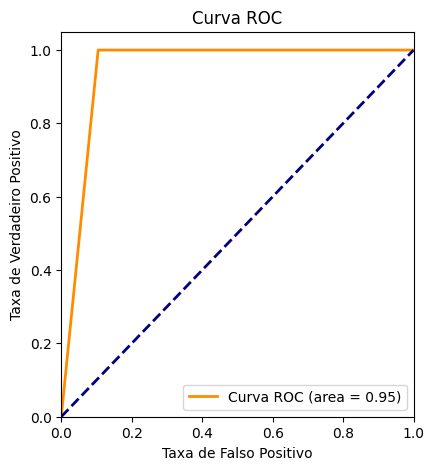

In [ ]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
confusion = confusion_matrix(y_test, y_pred_classes)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Matriz de Confusão:\n", confusion)

# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# model.save('meu_modelo_DL_ES_1000000_advanced.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')  # Usar sigmoid para classificação binária
])

# Compilação do modelo
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Checkpoint: Salvar pesos do modelo com melhor métrica
model_checkpoint = ModelCheckpoint('melhor_modelo.h5', monitor='val_loss', save_best_only=True)

# Treinamento do modelo com "infinitas" épocas
history = model.fit(X_train, y_train, epochs=100000, batch_size=5120,
                    validation_split=0.1, verbose=1,
                    callbacks=[model_checkpoint])

# Salvar o modelo completo (arquitetura, pesos e configurações) com os melhores pesos
model.load_weights('melhor_modelo.h5')
model.save('modelo_com_melhores_pesos_1000000.h5')

A saída de streaming foi truncada nas últimas 5000 linhas.
6/6 [==============================] - 0s 10ms/step - loss: 0.1012 - accuracy: 0.9555 - val_loss: 1.8653 - val_accuracy: 0.9144
Epoch 97502/100000
6/6 [==============================] - 0s 10ms/step - loss: 0.1017 - accuracy: 0.9554 - val_loss: 1.9125 - val_accuracy: 0.8980
Epoch 97503/100000
6/6 [==============================] - 0s 10ms/step - loss: 0.1020 - accuracy: 0.9552 - val_loss: 1.9291 - val_accuracy: 0.8921
Epoch 97504/100000
6/6 [==============================] - 0s 12ms/step - loss: 0.1025 - accuracy: 0.9548 - val_loss: 1.8970 - val_accuracy: 0.9075
Epoch 97505/100000
6/6 [==============================] - 0s 10ms/step - loss: 0.1007 - accuracy: 0.9557 - val_loss: 1.9000 - val_accuracy: 0.9013
Epoch 97506/100000
6/6 [==============================] - 0s 10ms/step - loss: 0.1011 - accuracy: 0.9556 - val_loss: 1.8912 - val_accuracy: 0.9049
Epoch 97507/100000
6/6 [==============================] - 0s 10ms/step - loss:

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_model = RandomForestClassifier(n_estimators=100000, verbose=1, random_state=42)

# Definir a grade de hiperparâmetros para pesquisa aleatória
param_dist = {
  'min_samples_split': randint(2, 11),    # Distribuição aleatória entre 2 e 10
  'min_samples_leaf': randint(1, 5),     # Distribuição aleatória entre 1 e 4
  'max_depth': [None] + list(range(10, 31))  # Valores específicos de max_depth
}

# Criar o objeto RandomizedSearchCV para a busca de hiperparâmetros com validação cruzada
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Executar a pesquisa de hiperparâmetros aleatória
random_search.fit(X_train, y_train)

# Imprimir os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(random_search.best_params_)

# Imprimir a melhor pontuação (acurácia) obtida
print("Melhor Acurácia:", random_search.best_score_)